In [39]:
import torch
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [40]:
# First, import the reload function
from importlib import reload

# Import your module normally
import func_tools

# Reload it to make sure changes are used
reload(func_tools)


<module 'func_tools' from '/home/naif/main/ml/cancer_project/Breast Cancer/func_tools.py'>

# Data Preparation

In [20]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


# Load and preprocess data
data = load_breast_cancer()
X, y = data.data, data.target

print("Original feature shape:", X.shape)
print("Original target shape:", y.shape)

# Display the first few rows
df = pd.DataFrame(X, columns=data.feature_names)
df.head()


Original feature shape: (569, 30)
Original target shape: (569,)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [21]:
#get class names
class_names = data.target_names
print("Class names:", class_names)

# Select all first features and later will analyze best features to use
feature_indices = [i for i in range(3)]  
X = X[:, feature_indices]
print("Selected features shape:", X.shape)

df = df.loc[:, data.feature_names[feature_indices]].copy()  # select only those columns
df['target'] = y

df.tail()

Class names: ['malignant' 'benign']
Selected features shape: (569, 3)


,mean radius,mean texture,mean perimeter,target
564,21.56,22.39,142.00,0
565,20.13,28.25,131.20,0
566,16.60,28.08,108.30,0
567,20.60,29.33,140.10,0
568,7.76,24.54,47.92,1


In [23]:
from func_tools import create_dataloaders
# Split data to train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#create dataloader
train_dataloader, test_dataloader = create_dataloaders(X_train, y_train, X_test, y_test, batch_size=32)


In [24]:
# Iterate over the first batch in train_loader and inspect
for __, (features, targets) in enumerate(train_dataloader):
    print("Inputs shape:", features.shape)   # Should be [batch_size, num_features]
    print("Targets shape:", targets.shape) # Should be [batch_size]
    print("Features example:\n", features[:2])  # Show first two samples (features)
    print("Targets example:\n", targets[:2]) # Show first two labels
    break  


Inputs shape: torch.Size([32, 3])
Targets shape: torch.Size([32])
Features example:
 tensor([[-0.8145,  3.3094, -0.8609],
        [ 0.1982, -1.0243,  0.1373]])
Targets example:
 tensor([1, 1])


### Model Creation

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Logistic Regression Model
from torch import nn

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)  # Output shape: [batch_size, num_classes]

    def forward(self, x):
        return self.linear(x) 


## 2. MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(input_dim, 32),
        nn.ReLU(),
        nn.Linear(32, 2)
    )

    
    def forward(self, x):
        return self.net(x)


### Train and Test the Models

In [26]:

torch.manual_seed(42)
from func_tools import train_step, test_step, print_train_time, accuracy_fn
from tqdm.auto import tqdm

from torch import nn
input_dim = X_train.shape[1] 

# Initialize the models
model_LR = LogisticRegression(input_dim, num_classes = 2)
model_MLP = MLP(input_dim)

models = [model_LR, model_MLP]  


for  model in models:
    # Print model name at the start of training
    model_name = model.__class__.__name__
    print(f"\nTraining model: {model_name}")
    print("=====================================================")
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    # Measure time
    from timeit import default_timer as timer
    time0 = timer()

    # Train and test model 
    epochs = 6
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n---------")
        train_step(data_loader=train_dataloader, 
            model=model, 
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device
        )
        
        # Test the model no optimization
        test_step(data_loader=test_dataloader,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device
        )

    time1 = timer()
    total_train_time_model = print_train_time(start=time0,
                                            end=time1,
                                            device=device)
    print("=====================================================")


Training model: LogisticRegression


 33%|███▎      | 2/6 [00:00<00:00, 15.91it/s]

Epoch: 0
---------
Train loss: 0.60484 | Train accuracy: 67.05%
Test loss: 0.50090 | Test accuracy: 78.04%
Epoch: 1
---------
Train loss: 0.46143 | Train accuracy: 79.55%
Test loss: 0.39390 | Test accuracy: 87.07%
Epoch: 2
---------
Train loss: 0.38415 | Train accuracy: 84.55%
Test loss: 0.33872 | Test accuracy: 92.36%
Epoch: 3
---------


100%|██████████| 6/6 [00:00<00:00, 15.70it/s]


Train loss: 0.32841 | Train accuracy: 87.71%
Test loss: 0.30829 | Test accuracy: 91.58%
Epoch: 4
---------
Train loss: 0.30031 | Train accuracy: 88.96%
Test loss: 0.28933 | Test accuracy: 90.97%
Epoch: 5
---------
Train loss: 0.29629 | Train accuracy: 88.84%
Test loss: 0.27601 | Test accuracy: 90.97%

Train time on cpu: 0.391 seconds

Training model: MLP


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0
---------


 33%|███▎      | 2/6 [00:00<00:00, 10.87it/s]

Train loss: 0.43972 | Train accuracy: 83.33%
Test loss: 0.28159 | Test accuracy: 90.19%
Epoch: 1
---------
Train loss: 0.24874 | Train accuracy: 91.04%
Test loss: 0.23477 | Test accuracy: 91.41%
Epoch: 2
---------
Train loss: 0.22040 | Train accuracy: 90.62%
Test loss: 0.24076 | Test accuracy: 91.41%
Epoch: 3
---------


100%|██████████| 6/6 [00:00<00:00, 13.83it/s]

Train loss: 0.22635 | Train accuracy: 90.83%
Test loss: 0.24062 | Test accuracy: 90.62%
Epoch: 4
---------
Train loss: 0.22500 | Train accuracy: 90.30%
Test loss: 0.24253 | Test accuracy: 90.62%
Epoch: 5
---------
Train loss: 0.22915 | Train accuracy: 89.14%
Test loss: 0.23639 | Test accuracy: 91.41%

Train time on cpu: 0.438 seconds


In [27]:
# Get model metrics in dictionary form 
from func_tools import eval_model
final_metrics0  = eval_model(
    model=model_LR,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
final_metrics1  = eval_model(
    model=model_MLP,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)


In [28]:
from func_tools import handle_metrics
#save metrics:
handle_metrics(final_metrics0, mode="save")
handle_metrics(final_metrics1, mode="save")

# display all saved metrics:
handle_metrics(mode="display")

Saved metrics.
Saved metrics.
Model Name                 Loss   Accuracy
---------------------------------------------
LogisticRegression       0.2760      90.97
MLP                      0.2364      91.41


# Feature Selection

### Top Feature Selection for Breast Cancer Classification with Extra Trees 

/tmp/ipykernel_86293/1049817167.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette=colors)
/tmp/ipykernel_86293/1049817167.py:26: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=top_features.values, y=top_features.index, palette=colors)


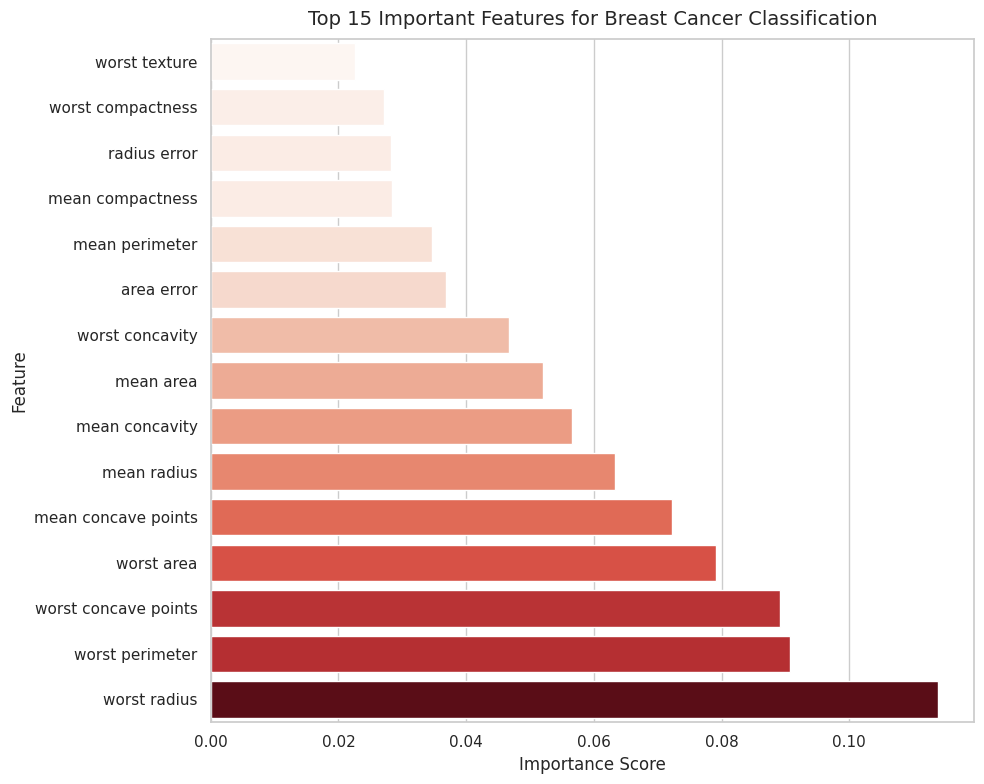

In [41]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler

# Load and preprocess data
data = load_breast_cancer()
dX = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')
X_scaled = StandardScaler().fit_transform(dX)

# Fit model
model = ExtraTreesClassifier(n_estimators=100, random_state=42)
model.fit(X_scaled, y)

# Get feature importances
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=dX.columns)
top_features = feature_importance.nlargest(15).sort_values(ascending=True)

# Normalize importances for colormap
norm = plt.Normalize(top_features.min(), top_features.max())
colors = plt.cm.Reds(norm(top_features.values)) 

# Plot
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
sns.barplot(x=top_features.values, y=top_features.index, palette=colors)

plt.title('Top 15 Important Features for Breast Cancer Classification', fontsize=14, pad=10)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


##### We keep features with importance ≥ 0.05 (5% relative importance).

# Studying Correlations between the top features

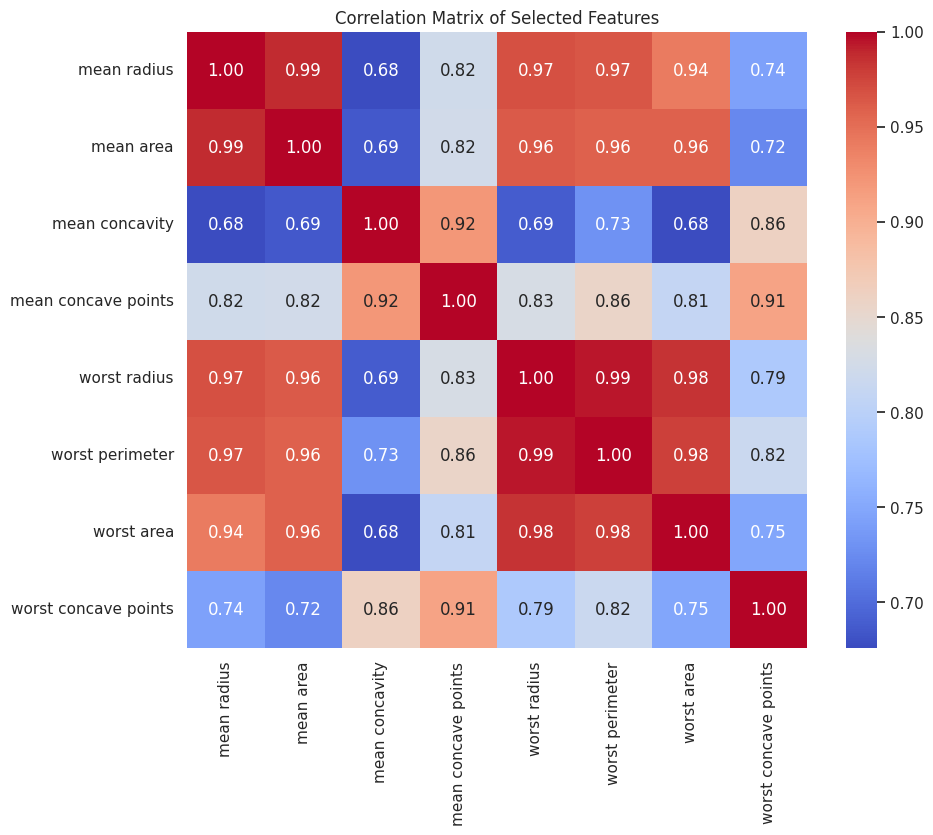

In [42]:
# Get the filtered features first
data = load_breast_cancer()

selected_features = feature_importance[feature_importance >= 0.05].index.tolist()
X_filtered = dX[selected_features]

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X_filtered.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Selected Features')
plt.show()

### We will remove the feature with the lowest score between any two highly correlated features with correlations higher than 85%

### we went from 
['mean radius',
 'mean area',
 'mean concavity',
 'mean concave points',
 'worst radius',
 'worst perimeter',
 'worst area',
 'worst concave points']

### to 
[ 'worst radius', 'mean concavity','worst concave points']


In [43]:
# Select only top features
final_features = [ 'worst radius', 'mean concavity','worst concave points']
X_top = dX[final_features]

# Split outside the function
X_train, X_test, y_train, y_test = train_test_split(X_top.values, y.values, test_size=0.2, random_state=42, stratify=y)

# Import your function from your file or just define above
train_dataloader, test_dataloader = create_dataloaders(X_train, y_train, X_test, y_test, batch_size=32)

# Verify
print("\nFiltered dataset shape:", X_top.shape)
print(X_top.head())
print('==================================================================')
print('==================================================================')


# Verify one batch
for __, (features, targets) in enumerate(train_dataloader):
    print("Inputs shape:", features.shape)   # Should be [batch_size, num_features]
    print("Targets shape:", targets.shape) # Should be [batch_size]
    print("Features example:\n", features[:2])  # Show first two samples (features)
    print("Targets example:\n", targets[:2]) # Show first two labels
    break  



Filtered dataset shape: (569, 3)
   worst radius  mean concavity  worst concave points
0         25.38          0.3001                0.2654
1         24.99          0.0869                0.1860
2         23.57          0.1974                0.2430
3         14.91          0.2414                0.2575
4         22.54          0.1980                0.1625
Inputs shape: torch.Size([32, 3])
Targets shape: torch.Size([32])
Features example:
 tensor([[-0.5346, -0.9797, -1.1093],
        [-1.2943, -0.3590, -0.9449]])
Targets example:
 tensor([1, 1])


### Training and Testing the models with the top selected features

In [44]:
torch.manual_seed(42)
from func_tools import train_step, test_step, print_train_time, accuracy_fn
from tqdm.auto import tqdm

from torch import nn
input_dim = X_train.shape[1] 

# Initialize the models
model_LR_v2 = LogisticRegression(input_dim, num_classes = 2)
model_MLP_v2 = MLP(input_dim)
models = [model_LR_v2, model_MLP_v2]

for model in models:
    # Print model name at the start of training
    model_name = model.__class__.__name__
    print(f"\nTraining model: {model_name}")
    print("=====================================================")
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)



    # Measure time
    from timeit import default_timer as timer
    time0 = timer()

    # Train and test model 
    epochs = 4
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n---------")
        train_step(data_loader=train_dataloader, 
            model=model, 
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device
        )
        
        # Test the model no optimization
        test_step(data_loader=test_dataloader,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device
        )

    time1 = timer()
    total_train_time_model = print_train_time(start=time0,
                                            end=time1,
                                            device=device)
    print("=====================================================")


Training model: LogisticRegression


  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.58it/s]

Epoch: 0
---------
Train loss: 0.49453 | Train accuracy: 77.59%
Test loss: 0.39894 | Test accuracy: 87.07%
Epoch: 1
---------


100%|██████████| 4/4 [00:00<00:00,  9.47it/s]


Train loss: 0.34996 | Train accuracy: 88.96%
Test loss: 0.29425 | Test accuracy: 93.75%
Epoch: 2
---------
Train loss: 0.28771 | Train accuracy: 89.97%
Test loss: 0.24258 | Test accuracy: 93.14%
Epoch: 3
---------
Train loss: 0.24392 | Train accuracy: 92.92%
Test loss: 0.21473 | Test accuracy: 93.92%

Train time on cpu: 0.435 seconds

Training model: MLP


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
---------


 25%|██▌       | 1/4 [00:00<00:00,  8.24it/s]

Train loss: 0.39873 | Train accuracy: 88.33%
Test loss: 0.19918 | Test accuracy: 96.09%
Epoch: 1
---------


 50%|█████     | 2/4 [00:00<00:00,  6.47it/s]

Train loss: 0.15909 | Train accuracy: 94.79%
Test loss: 0.12106 | Test accuracy: 93.92%
Epoch: 2
---------


100%|██████████| 4/4 [00:00<00:00,  8.85it/s]

Train loss: 0.12679 | Train accuracy: 95.21%
Test loss: 0.11891 | Test accuracy: 93.14%
Epoch: 3
---------
Train loss: 0.12744 | Train accuracy: 94.67%
Test loss: 0.11530 | Test accuracy: 94.70%

Train time on cpu: 0.462 seconds


In [45]:
# Get model metrics in dictionary form 
from func_tools import eval_model
final_metrics0  = eval_model(
    model=model_LR_v2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
final_metrics1  = eval_model(
    model=model_MLP_v2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
final_metrics0 

{'model_name': 'LogisticRegression',
 'model_loss': 0.21472714841365814,
 'model_acc': 93.92361111111111}

In [46]:
from func_tools import handle_metrics
#save metrics:
handle_metrics(final_metrics0, mode="save", filename="models_v2.json")
handle_metrics(final_metrics1, mode="save", filename="models_v2.json")

# display all saved metrics:
handle_metrics(mode="display", filename="models_v2.json")

Saved metrics.
Saved metrics.
Model Name                 Loss   Accuracy
---------------------------------------------
LogisticRegression       0.2147      93.92
MLP                      0.1153      94.70
LogisticRegression       0.2147      93.92
MLP                      0.1153      94.70


# Confuison Matrix

100%|██████████| 1/1 [00:00<00:00, 50.43it/s]

Test loss: 0.21473 | Test accuracy: 93.92%

Train time on cpu: 0.033 seconds
[[37  5]
 [ 2 70]]


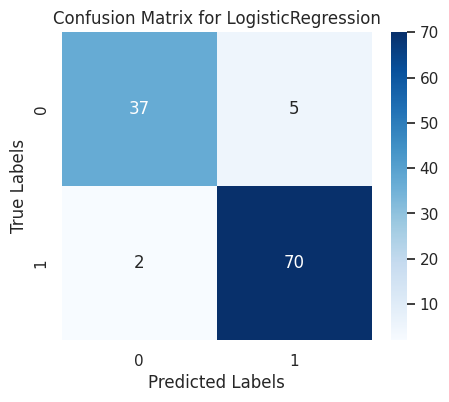

100%|██████████| 1/1 [00:00<00:00, 90.97it/s]


Test loss: 0.11530 | Test accuracy: 94.70%

Train time on cpu: 0.014 seconds
[[40  2]
 [ 4 68]]


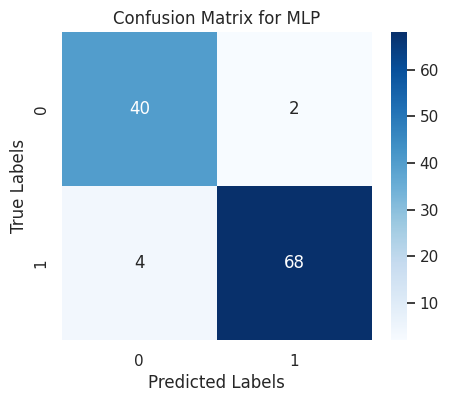

In [56]:
from sklearn.metrics import confusion_matrix
cms = []
for model in models:
    model_name = model.__class__.__name__

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

    time0 = timer()
    epochs = 1

    for epoch in tqdm(range(epochs)):
        all_preds, all_labels = test_step(
            test_dataloader, model, loss_fn, accuracy_fn, device
        )

    time1 = timer()
    print_train_time(start=time0, end=time1, device=device)
    print("=====================================================")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cms.append(cm)
    print(cm)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


In [62]:
#LogisticRegression
cm = cms[0]
TP = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]
TN = cm[0, 0]

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print('LogisticRegression')
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print('========================================================')
print('========================================================')
#MLP
cm = cms[1]
TP = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]
TN = cm[0, 0]

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print('MLP')
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1_score:.4f}")

LogisticRegression
Precision: 0.9333
Recall (Sensitivity): 0.9722
Specificity: 0.8810
F1-Score: 0.9524
MLP
Precision: 0.9714
Recall (Sensitivity): 0.9444
Specificity: 0.9524
F1-Score: 0.9577


# ROC & AUC
We will use the **ROC curve** even when accuracy is high because accuracy alone can be misleading, especially with **imbalanced datasets** like breast cancer classification. ROC evaluates the **true positive rate vs. false positive rate** at various thresholds, giving a fuller picture of model performance. A high accuracy might mask poor performance in detecting malignant cases, but the ROC curve and AUC score reveal how well the model **distinguishes between classes**, which is critical in medical diagnosis.


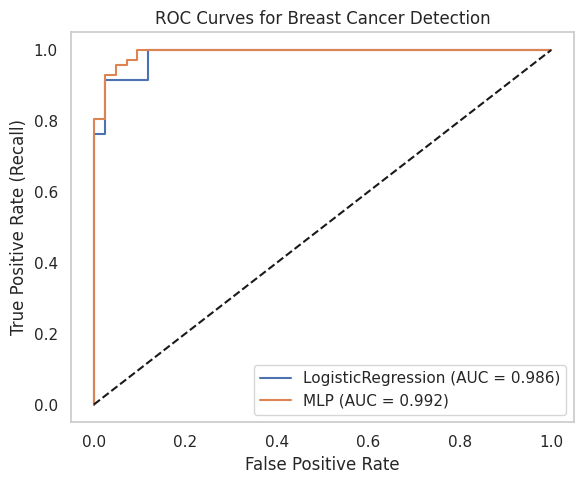

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve
import torch.nn.functional as F

# Store results
roc_results = []

# Evaluate each model
models = [model_LR_v2, model_MLP_v2]
for model in models:
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            logits = model(X_batch)
            probs = F.softmax(logits, dim=1)[:, 1]  # Probabilities of class 1
            all_probs.extend(probs.numpy())
            all_labels.extend(y_batch.numpy())

    # Compute ROC & AUC
    auc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    model_name = model.__class__.__name__
    roc_results.append((model_name, fpr, tpr, auc))

# Plot all ROC curves
plt.figure(figsize=(6, 5))
for name, fpr, tpr, auc in roc_results:
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves for Breast Cancer Detection')
plt.legend()
plt.grid(alpha=0)
plt.tight_layout()
plt.show()


**final Model Selection:**

Both the Logistic Regression and MLP models performed well on the breast cancer classification task, achieving high accuracy and low loss. The MLP slightly outperformed Logistic Regression in both accuracy (94.70% vs. 93.92%) and loss (0.1153 vs. 0.2147), indicating better overall fit. Importantly, the ROC AUC scores — 0.992 for the MLP and 0.986 for Logistic Regression — show that both models have excellent discriminative ability. The MLP’s higher AUC confirms it is slightly more effective at distinguishing between malignant and benign cases, making it the preferred model in this context.

**Final Model Selection**

***Before Feature Selection Process:***

| Metric            | MLP Model      | Logistic Regression | 
|-------------------|---------------|----------------------|
| **Accuracy**      | 91.40%        | 90.97%               | 
| **Loss**         | 0.2363        | 0.2760               | 


***After Feature Selection Process:***

| Metric             | MLP Model    | Logistic Regression |
|--------------------|--------------|---------------------|
| **Accuracy**       | 94.70%       | 93.92%              |
| **Loss**           | 0.1153       | 0.2147              |
| **ROC AUC**        | 0.992        | 0.986               |
| **Precision**      | 0.9714       | 0.9333              |
| **Recall (Sensitivity)** | 0.9444  | 0.9722              |
| **Specificity**    | 0.9524       | 0.8810              |
| **F1-Score**       | 0.9577       | 0.9524              |


<style>
    table {box-shadow: 0 4px 8px rgba(0,0,0,0.1); border-collapse: collapse; width: 80%; margin: 20px auto;}
    th {background-color: #f8f9fa; text-align: center !important;}
    td {border: 1px solid #ddd; padding: 8px; text-align: center;}
    tr:nth-child(even) {background-color: #f2f2f2;}
</style>


Conclusion: The MLP is preferred due to its slightly better performance across all metrics, especially its superior ability to distinguish malignant/benign cases (higher AUC).


# Visualization

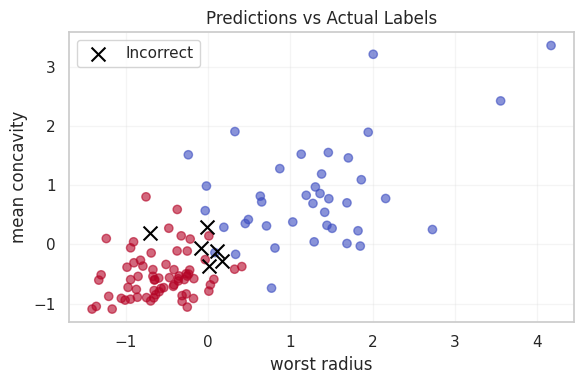

In [38]:
def visualize_predictions(model, dataloader, feature_names=None):
    """Visualize model predictions vs actual labels using first 2 features"""
    model.eval()
    
    X, y_true, y_pred = [], [], []
    with torch.no_grad():
        for features, targets in dataloader:
            X.append(features)
            y_true.append(targets)
            y_pred.append(model(features).argmax(dim=1))
    
    X = torch.cat(X).numpy()
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    
    correct = y_pred == y_true
    
    plt.figure(figsize=(6, 4))
    plt.scatter(X[correct, 0], X[correct, 1], c=y_true[correct], cmap='coolwarm', alpha=0.6)
    plt.scatter(X[~correct, 0], X[~correct, 1], c='black', marker='x', s=100, label='Incorrect')
    
    xlabel = feature_names[0] if feature_names else 'Feature 1'
    ylabel = feature_names[1] if feature_names else 'Feature 2'
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('Predictions vs Actual Labels')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()



final_features = [ 'worst radius', 'mean concavity','worst concave points']
visualize_predictions(model_MLP_v2, test_dataloader, feature_names=[final_features[0],final_features[1]])